Here we are going to learn the oscillating behaviour from time-series data using neural network.

In [1]:
import sys
sys.path.append("./source")

import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from generate_dataset import generate_dataset
from train_classic import train_classic
from compute_error import compute_error
from predict_classic import predict_integrate

# 1. Data Preparation

As usual we will create pairs of features and targets (numerical derivatives) from time-series data.

In [2]:
# load data
with open('./data/cell_cycle.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    
data_array = data_dict['data']
time_points = data_dict['t']

# create the dataframe with strain as index

df = pd.DataFrame(data_array.numpy()[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df['Time'] = time_points
df.head()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
Strain,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761,0.2
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450,0.4
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087,0.6
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058,0.8


In [3]:
df.shape

(7500, 8)

In [4]:
# now generate and augment the training dataset

feature_list = [] # here we do not have external time-series or control variables
target_list = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df_train = generate_dataset(df, [0],feature_list, target_list, n_dim=7500)
display(df_train)

feature    target   feature    target   feature    target  \
                 cyclin    cyclin       MPF       MPF    preMPF    preMPF   
Strain Time                                                                 
0      0.0     0.003005  0.898144 -0.003425  0.079749  0.000862 -0.006695   
       0.2     0.182610  0.849663  0.012522  0.093314 -0.000477  0.006907   
       0.4     0.342825  0.752702  0.033895  0.120443  0.003625  0.034111   
       0.6     0.483650  0.648810  0.060693  0.154785  0.013166  0.059963   
       0.8     0.602314  0.552382  0.095801  0.180759  0.027607  0.087821   
...                 ...       ...       ...       ...       ...       ...   
       1499.0  1.998806  0.025684  3.987817  0.203401  5.824301  0.339751   
       1499.2  2.003932  0.025581  4.028745  0.205961  5.892361  0.340860   
       1499.4  2.009038  0.025479  4.070191  0.208535  5.960627  0.341928   
       1499.6  2.014122  0.025376  4.112148  0.211095  6.029114  0.343036   
       1499.8  2.019187  0.025325  4.154617  0.212375  6.097823  0.343590   

                feature    target   feature    target   feature    target  \
                 cdc25P    cdc25P     wee1P     wee1P       IEP       IEP   
Strain Time                                                                 
0      0.0     0.000021 -0.000169  0.000011 -0.000086  1.000026 -0.148749   
       0.2    -0.000013  0.000119 -0.000007  0.000061  0.970280 -0.148432   
       0.4     0.000069  0.000697  0.000035  0.000355  0.940661 -0.147797   
       0.6     0.000266  0.001237  0.000135  0.000631  0.911169 -0.147211   
       0.8     0.000563  0.001827  0.000287  0.000932  0.881784 -0.146563   
...                 ...       ...       ...       ...       ...       ...   
       1499.0  3.937864 -0.006855  0.363066  0.004398  0.010790  0.001109   
       1499.2  3.936569 -0.006089  0.363970  0.004640  0.011015  0.001146   
       1499.4  3.935429 -0.005320  0.364922  0.004882  0.011248  0.001185   
       1499.6  3.934441 -0.004555  0.365922  0.005125  0.011489  0.001222   
       1499.8  3.933607 -0.004172  0.366971  0.005246  0.011737  0.001241   

                feature    target  
                    APC       APC  
Strain Time                        
0      0.0     0.998996 -0.019489  
       0.2     0.995099 -0.017445  
       0.4     0.992019 -0.013358  
       0.6     0.989757 -0.007581  
       0.8     0.988987 -0.004098  
...                 ...       ...  
       1499.0  0.128617 -0.013430  
       1499.2  0.125962 -0.013132  
       1499.4  0.123365 -0.012835  
       1499.6  0.120828 -0.012536  
       1499.8  0.118351 -0.012387  

[7500 rows x 14 columns]

# 2. Training

Now let's do two things: Random Forest and Neural Network

In [5]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)

cyclin


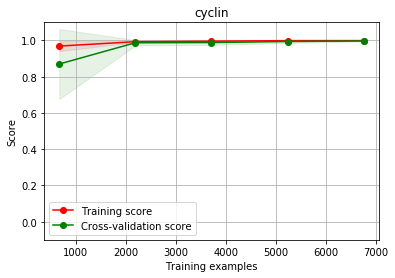

Target: cyclin, CV Pearson R2 coefficient: 0.999843
MPF


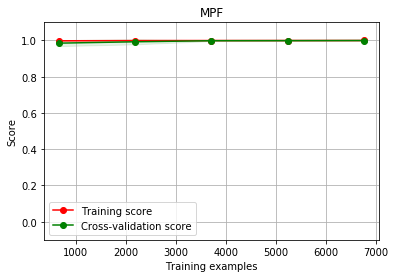

Target: MPF, CV Pearson R2 coefficient: 0.999970
preMPF


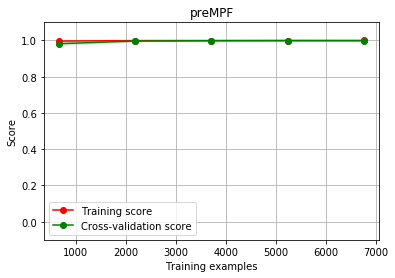

Target: preMPF, CV Pearson R2 coefficient: 0.999935
cdc25P


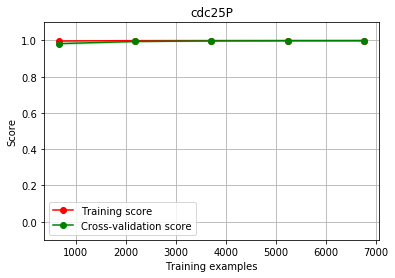

Target: cdc25P, CV Pearson R2 coefficient: 0.999873
wee1P


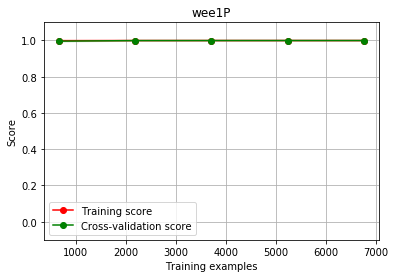

Target: wee1P, CV Pearson R2 coefficient: 0.999876
IEP


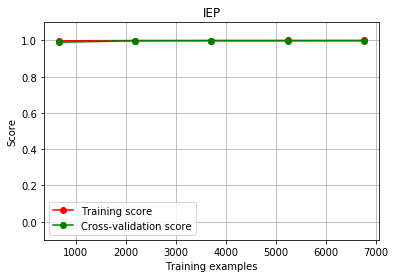

Target: IEP, CV Pearson R2 coefficient: 0.999931
APC


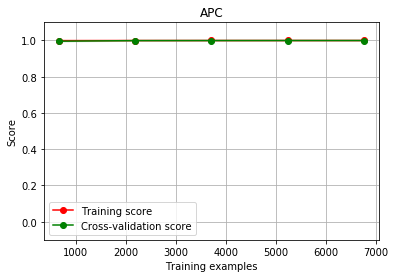

Target: APC, CV Pearson R2 coefficient: 0.999974
Average training score: 0.9999144472900009


In [6]:
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

cyclin RMSE: 9.749551201628854e-06 standard deviation: 0.0005121179643006595


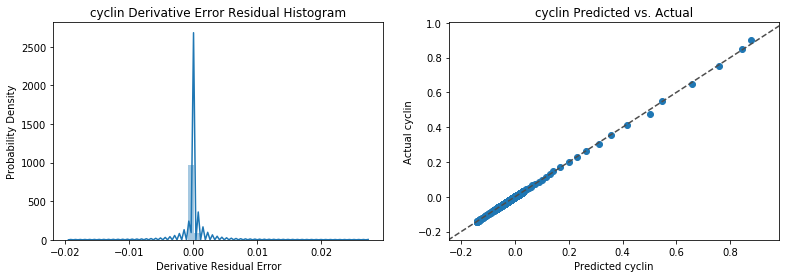

MPF RMSE: -4.765070555472374e-05 standard deviation: 0.002014439294999376


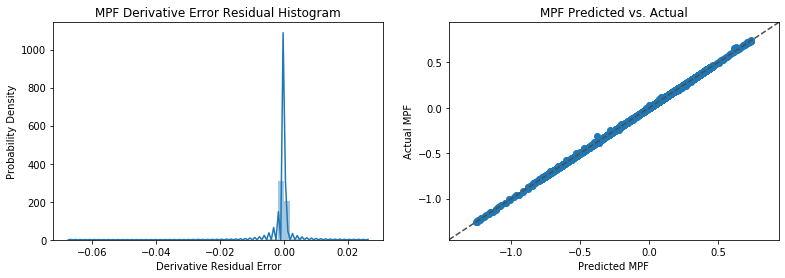

preMPF RMSE: 0.0001307158398507468 standard deviation: 0.0027809559659689336


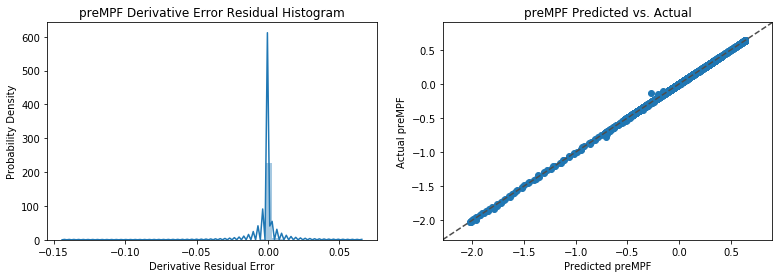

cdc25P RMSE: -2.721906177016122e-05 standard deviation: 0.0004785941640536933


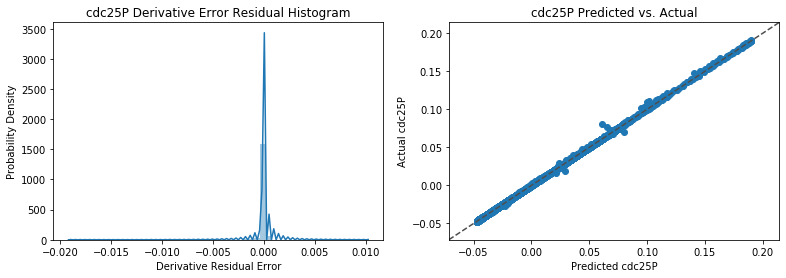

wee1P RMSE: 1.3018944448585682e-06 standard deviation: 0.00014972277842830066


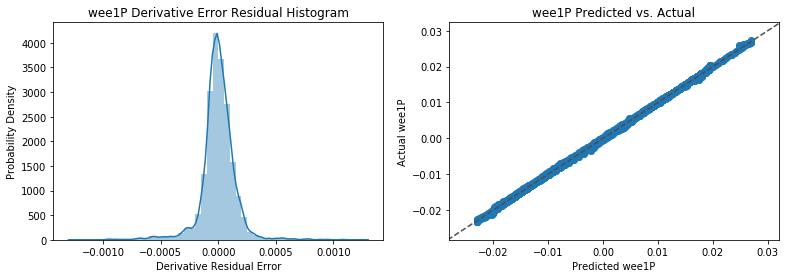

IEP RMSE: -7.043599091008187e-07 standard deviation: 0.000357254997127728


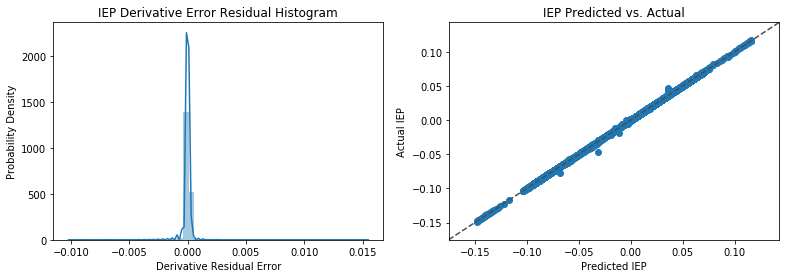

APC RMSE: -5.511647649980218e-06 standard deviation: 0.0001663090207186537


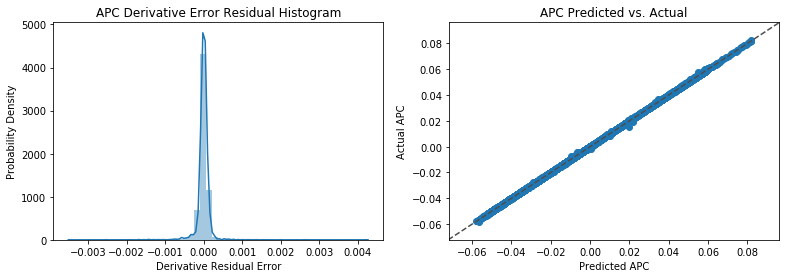

Total Derivative Mean Error: 0.8600509469244092 Error Standard Deviation: 0.016691759248606403


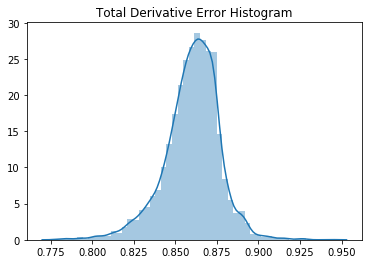

In [7]:
# generate reports on the residual errors
compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

Real data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058
...,...,...,...,...,...,...,...
0,1.998806,3.987818,5.824301,3.937864,0.363066,0.010790,0.128617
0,2.003932,4.028746,5.892361,3.936569,0.363970,0.011015,0.125962
0,2.009037,4.070185,5.960643,3.935427,0.364922,0.011248,0.123366


Predicted data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Time,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0.2,0.173347,0.018290,0.002949,0.000040,0.000043,0.970346,0.996532
0.4,0.332422,0.039513,0.008651,0.000120,0.000088,0.940744,0.993433
0.6,0.473593,0.067823,0.018983,0.000324,0.000164,0.911250,0.991298
0.8,0.593506,0.100342,0.036188,0.000608,0.000301,0.881840,0.989795
...,...,...,...,...,...,...,...
1499.0,1.987783,-347.500457,-1327.356545,-5.037838,0.634860,-32.363202,1.401200
1499.2,1.985741,-347.549893,-1327.539190,-5.039042,0.635352,-32.367875,1.401220
1499.4,1.983698,-347.599329,-1327.721835,-5.040246,0.635843,-32.372549,1.401240


./source/predict_classic.py:216: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_classic.py:221: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: cyclin 12.808499386262195 RMSE percentage: 38.12196657727889


./source/predict_classic.py:221: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: MPF 7710.215929245545 RMSE percentage: 638.6078601138908
ML Fit: preMPF 29327.299390194483 RMSE percentage: 1254.050472479806
ML Fit: cdc25P 224.02402928324653 RMSE percentage: 108.82722909482703
ML Fit: wee1P 7.049289749544326 RMSE percentage: 59.851928734797575
ML Fit: IEP 704.5728426899632 RMSE percentage: 3220.326646802712
ML Fit: APC 49.767227693922244 RMSE percentage: 287.7333631620024
ML model aggregate error
Average RMSE: 5433.676744034709
Total percentage error: 801.0742095664735


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


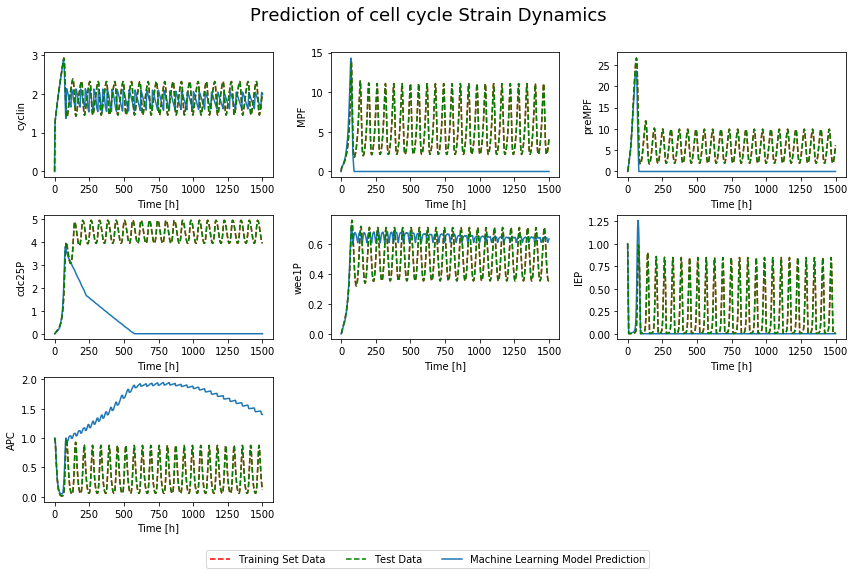

In [8]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe

time_points, predictions = predict_integrate(df, df, rf_dict, target_list, feature_list, title='cell cycle', plot=True,model_type='random_forest')

Here, we actually use more data (7500 time points) relative to the previous notebook. However, here the model is able to learn only the first period of the true integrated dynamics. This is perhaps because small errors in the predictions of derivatives compound quickly. This causes eventual deviation from the true qualitative behaviour.

In [9]:
# now we increase the number of trees to 150 estimators

rf_model = RandomForestRegressor(n_estimators=150)

cyclin


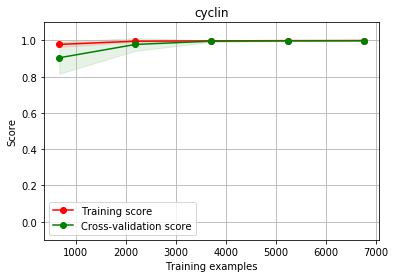

Target: cyclin, CV Pearson R2 coefficient: 0.999744
MPF


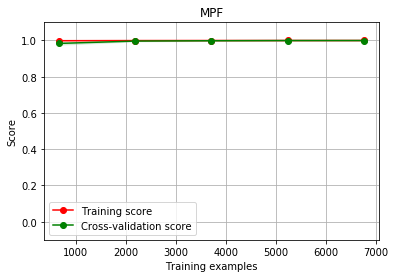

Target: MPF, CV Pearson R2 coefficient: 0.999984
preMPF


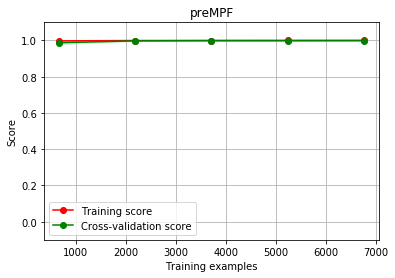

Target: preMPF, CV Pearson R2 coefficient: 0.999943
cdc25P


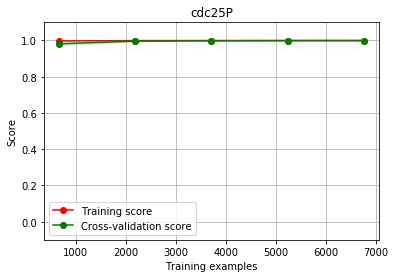

Target: cdc25P, CV Pearson R2 coefficient: 0.999895
wee1P


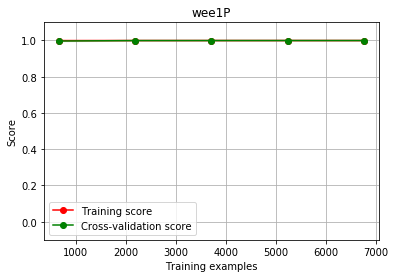

Target: wee1P, CV Pearson R2 coefficient: 0.999891
IEP


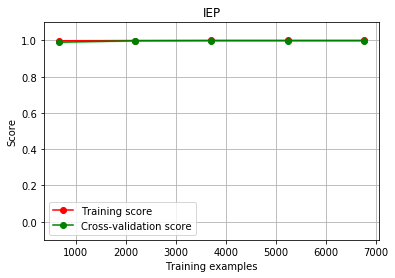

Target: IEP, CV Pearson R2 coefficient: 0.999965
APC


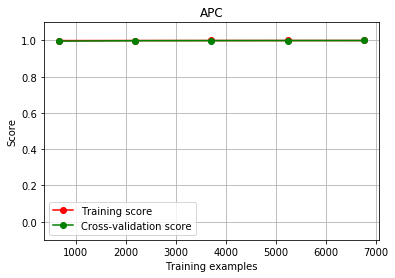

Target: APC, CV Pearson R2 coefficient: 0.999981
Average training score: 0.999914626940057


In [10]:
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

cyclin RMSE: 4.044275471188908e-06 standard deviation: 0.0006540900692316091


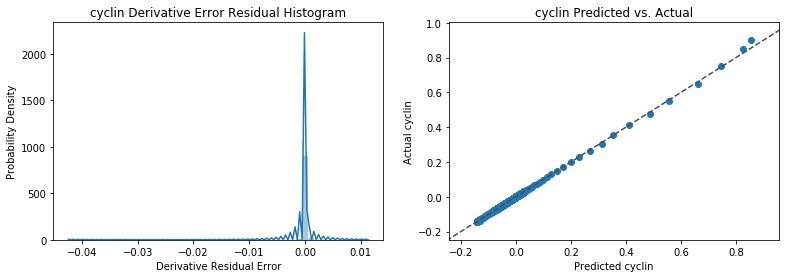

MPF RMSE: -2.7927809969941353e-05 standard deviation: 0.0014666712103538389


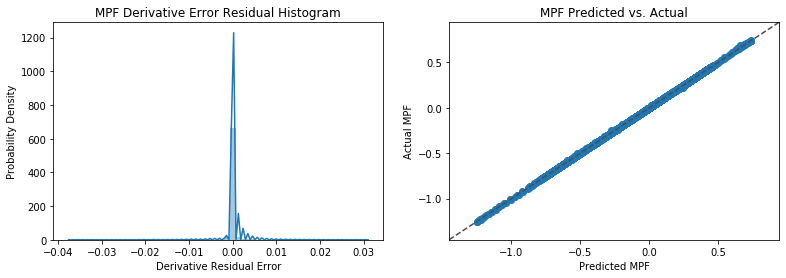

preMPF RMSE: 0.00010342947334155661 standard deviation: 0.0025985755685569135


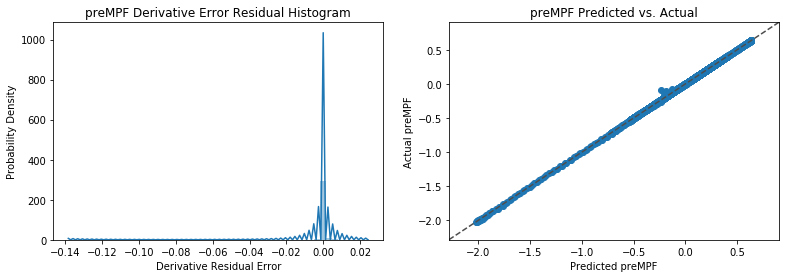

cdc25P RMSE: -2.452078409762949e-05 standard deviation: 0.0004363290293372662


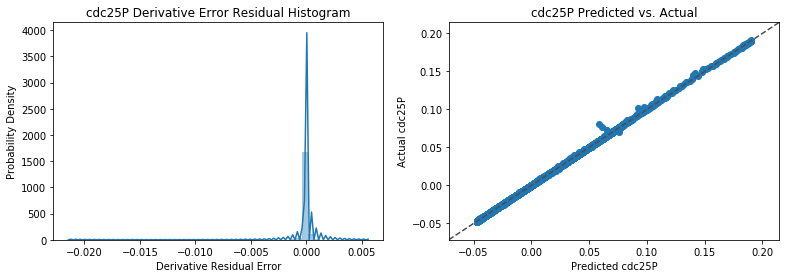

wee1P RMSE: 1.7842059020164354e-06 standard deviation: 0.0001399862322471488


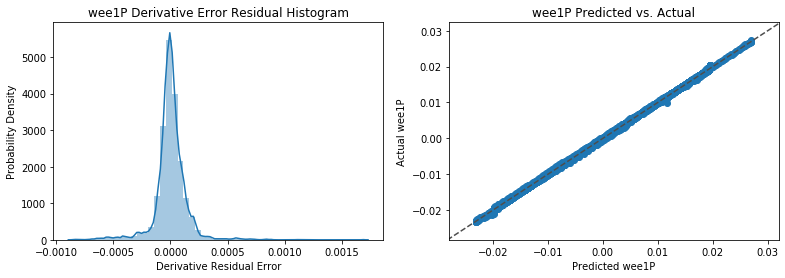

IEP RMSE: -1.4605592551522806e-06 standard deviation: 0.0002541347094446311


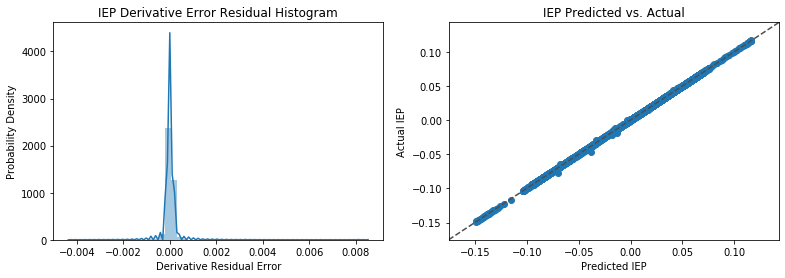

APC RMSE: -4.842678974679808e-06 standard deviation: 0.000144328779688152


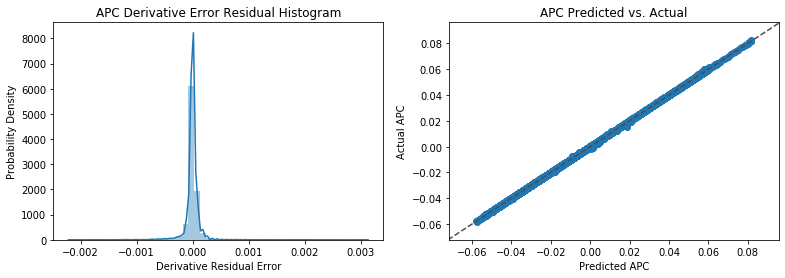

Total Derivative Mean Error: 0.8587367043240287 Error Standard Deviation: 0.017633516160818062


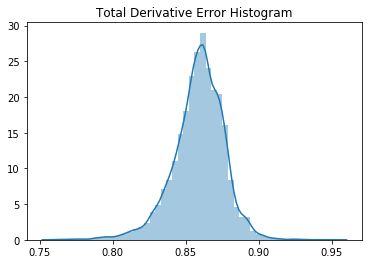

In [11]:
# generate reports on the residual errors
compute_error(df_train,rf_dict,plot=True,model_type='random_forest', figure_path=figure_path)

Real data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Strain,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0,0.185745,0.008765,0.000595,0.000012,0.000006,0.970310,0.993761
0,0.345694,0.030825,0.004259,0.000085,0.000043,0.940683,0.991450
0,0.483463,0.061154,0.012881,0.000260,0.000133,0.911164,0.990087
0,0.602154,0.096144,0.027416,0.000560,0.000285,0.881781,0.989058
...,...,...,...,...,...,...,...
0,1.998806,3.987818,5.824301,3.937864,0.363066,0.010790,0.128617
0,2.003932,4.028746,5.892361,3.936569,0.363970,0.011015,0.125962
0,2.009037,4.070185,5.960643,3.935427,0.364922,0.011248,0.123366


Predicted data:


,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC
Time,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
0.2,0.169194,0.018677,0.001811,0.000029,0.000038,0.970326,0.996527
0.4,0.329129,0.039615,0.005826,0.000116,0.000080,0.940700,0.993477
0.6,0.471590,0.066071,0.014689,0.000301,0.000155,0.911180,0.991109
0.8,0.594629,0.098443,0.028095,0.000569,0.000286,0.881780,0.989689
...,...,...,...,...,...,...,...
1499.0,1.679747,-339.757798,-1445.402226,-6.813687,0.675557,-22.061640,0.960690
1499.2,1.676519,-339.806419,-1445.606162,-6.815039,0.675508,-22.065010,0.962429
1499.4,1.673291,-339.855040,-1445.810097,-6.816390,0.675461,-22.068380,0.964168


./source/predict_classic.py:216: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_classic.py:221: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: cyclin 16.30790911255041 RMSE percentage: 42.172830633513364


./source/predict_classic.py:216: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_classic.py:221: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: MPF 7525.528881157187 RMSE percentage: 630.1925909560091
ML Fit: preMPF 31693.265851604156 RMSE percentage: 1301.9028193144368
ML Fit: cdc25P 256.6713076209746 RMSE percentage: 115.5411488823927
ML Fit: wee1P 7.252004268278979 RMSE percentage: 60.78704534782371
ML Fit: IEP 480.64312029526815 RMSE percentage: 2645.2179208920647
ML Fit: APC 41.07855484943452 RMSE percentage: 249.97571417575674
ML model aggregate error
Average RMSE: 5717.24966127255
Total percentage error: 720.8271528859997


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


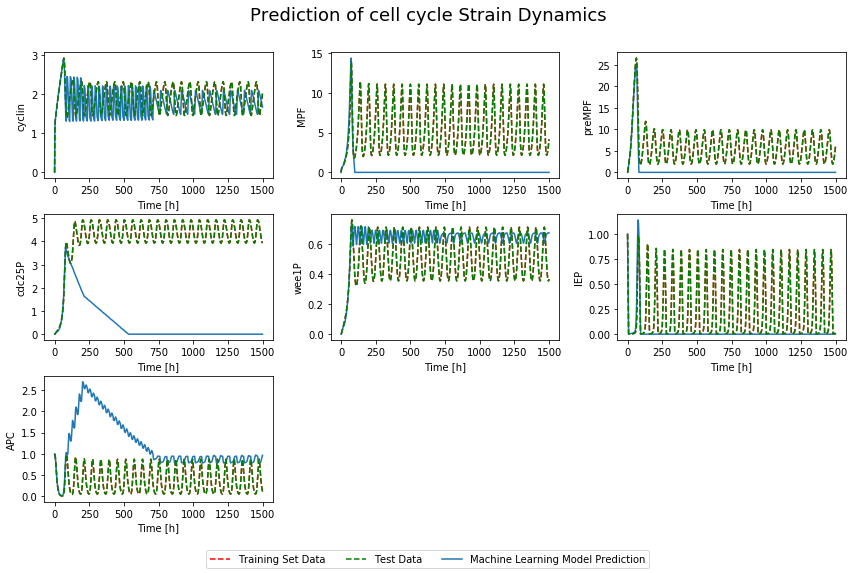

In [12]:
time_points, predictions = predict_integrate(df, df, rf_dict, target_list, feature_list, title='cell cycle', plot=True,model_type='random_forest', figure_path=figure_path)

We see that the qualitative behaviour of oscillation is predicted in cyclin, wee1P, and APC. For APC, the predicted dynamics is oscillating at the steady state.

In [13]:
# create a pipeline 
nn_model = Pipeline([('Scaler',StandardScaler()),
                            ('neural_net',MLPRegressor(hidden_layer_sizes=(10, 10, 10),
                                                       learning_rate_init=0.1,
                                                       learning_rate='adaptive',
                                                       solver='adam',
                                                       activation='tanh',
                                                       max_iter=1000))])

cyclin


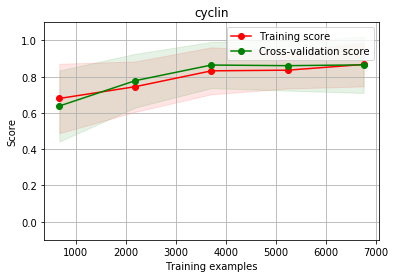

Target: cyclin, CV Pearson R2 coefficient: 0.905354
MPF


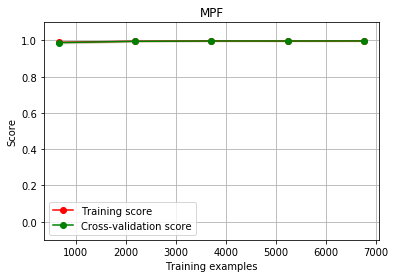

Target: MPF, CV Pearson R2 coefficient: 0.999207
preMPF


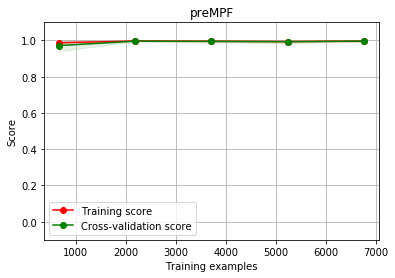

Target: preMPF, CV Pearson R2 coefficient: 0.997986
cdc25P


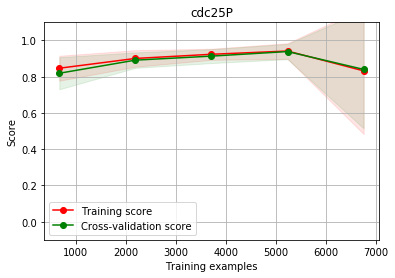

Target: cdc25P, CV Pearson R2 coefficient: 0.977490
wee1P


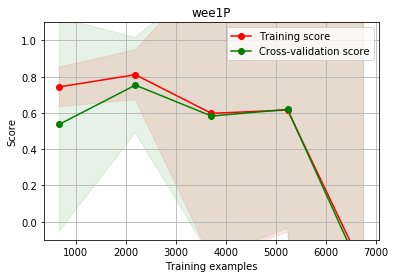

Target: wee1P, CV Pearson R2 coefficient: 0.965661
IEP


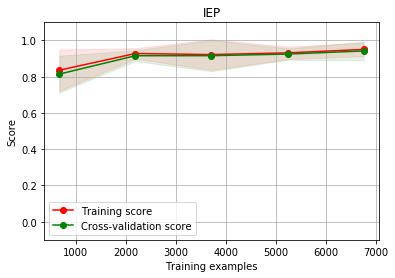

Target: IEP, CV Pearson R2 coefficient: 0.940429
APC


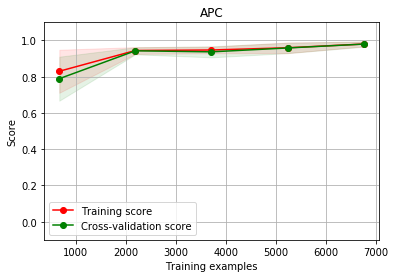

Target: APC, CV Pearson R2 coefficient: 0.977851
Average training score: 0.9662825514800586


In [16]:
figure_path = './plots/'

# train a model
nn_dict, score_dict = train_classic(df_train, nn_model, plot=True,model_type='neural_network', figure_path=figure_path)

cyclin RMSE: -0.003998270558789165 standard deviation: 0.011925542287518269


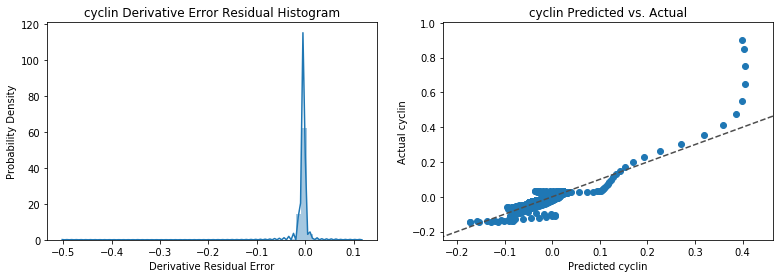

MPF RMSE: 0.0010043231131069887 standard deviation: 0.010259302840080725


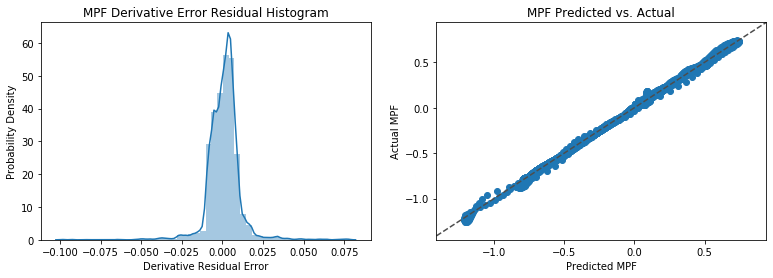

preMPF RMSE: 0.00632235269781475 standard deviation: 0.014100596510704088


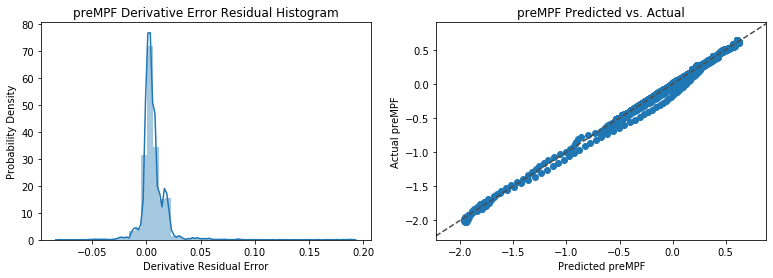

cdc25P RMSE: 0.0026127713919768796 standard deviation: 0.005834017166377933


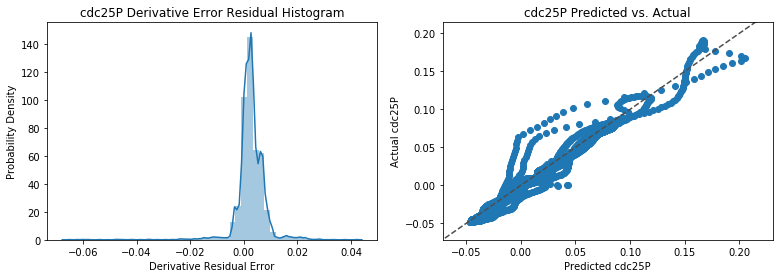

wee1P RMSE: 2.113290666020544e-05 standard deviation: 0.0024870088601128704


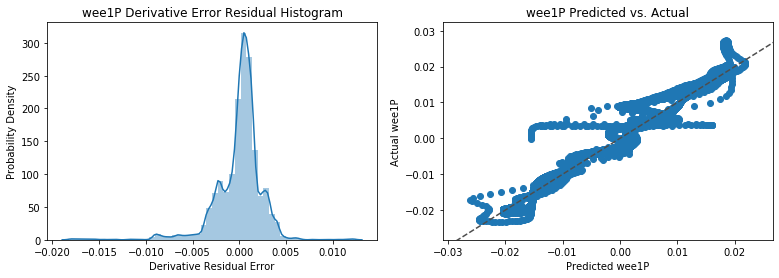

IEP RMSE: -0.004901352331119017 standard deviation: 0.009242779883047657


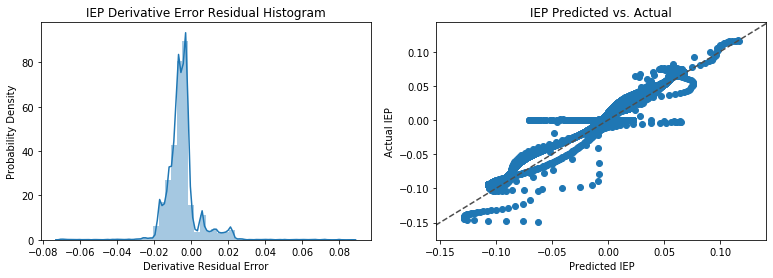

APC RMSE: -0.0004297480826561216 standard deviation: 0.004860739743000956


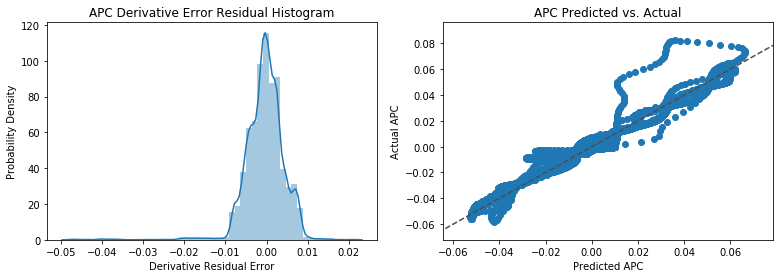

Total Derivative Mean Error: 0.9168078740639989 Error Standard Deviation: 0.01354800044376817


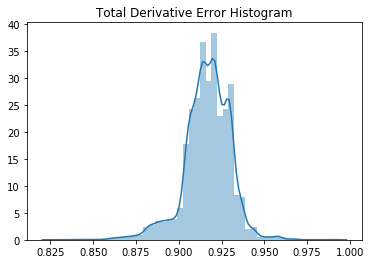

In [17]:
# generate reports on the residual errors
compute_error(df_train,nn_dict,plot=True, figure_path=figure_path)

In [ ]:
time_points, predictions = predict_integrate(df, df, rf_dict, target_list, feature_list, title='cell cycle', plot=True,model_type='neural_network', figure_path=figure_path)